PS 3 - Question 2 <br>
Inference and  Representation<br>
NYU Center for Data Science<br>
October 3, 2017

It is a Python adaptation of the Matlab code provided in Brown University CS242 Homework 1:
http://cs.brown.edu/courses/cs242/assignments/
The factor graph library (fglib) is a Python 3 package to simulate message passing on factor graphs: https://github.com/danbar/fglib

# 2. Sum-product algorithm

In [1]:
import numpy as np 
import networkx as nx
from fglib import graphs, nodes, rv, inference

def make_debug_graph():

    # Create factor graph
    fg = graphs.FactorGraph()

    # Create variable nodes
    x1 = nodes.VNode("x1")
    x2 = nodes.VNode("x2")
    x3 = nodes.VNode("x3")
    x4 = nodes.VNode("x4")

    # Create factor nodes
    f12 = nodes.FNode("f12")
    f234 = nodes.FNode("f234")
    f3 = nodes.FNode("f3")
    f4 = nodes.FNode("f4")

    # Add nodes to factor graph
    fg.set_nodes([x1, x2, x3, x4])
    fg.set_nodes([f12, f234, f3,f4 ])

    # Add edges to factor graph
    fg.set_edge(x1, f12)
    fg.set_edge(f12, x2)
    fg.set_edge(x2, f234)
    fg.set_edge(f234, x3)
    fg.set_edge(f234, x4)
    fg.set_edge(x3, f3)
    fg.set_edge(x4, f4)

    #add potential for f_3: p(x3)
    dist_f3 = [0.5, 0.5]
    f3.factor = rv.Discrete(dist_f3,x3)
    
    #add potential for f_4: p(x4)
    dist_f4 = [0.4,0.6]
    f4.factor = rv.Discrete(dist_f4,x4)
    
    # add potential for f_{234}: p(x2, x3, x4) = p(x2|x3,x4) p(x3,x4)
    px3x4=np.outer(dist_f3,dist_f4)
    px3x4=np.reshape(px3x4, np.shape(px3x4)+(1,))
    px2_conditioned_x3x4=[[[0.2,0.8],
                         [0.25,0.75],],
                         [[0.7,0.3],
                         [0.3,0.7]]]
    
    dist_f234 =px3x4*px2_conditioned_x3x4
    f234.factor = rv.Discrete(dist_f234,x3,x4,x2)
   
    # add potential for f_{12}:  p (x1,x2) = p(x1 | x2) p(x2)
    px1_conditioned_x2 = [[0.5,0.5],
                         [0.7,0.3]]
    px2= np.sum(dist_f234, axis=(0,1))
    dist_f12 =px2[:,np.newaxis]*px1_conditioned_x2
    f12.factor = rv.Discrete(dist_f12,x2,x1)
    # Perform sum-product algorithm on factor graph
    # and request belief of variable node x1
    belief = inference.sum_product(fg, x3)
    return (fg)


In [2]:
from collections import OrderedDict
# Update belief given a edge visiting schedule
def schedule_propagation(schedule, graph):
    '''
    schedule: list of edges (in tuple form)parralel_update
    '''
    for node_origin, node_destination in schedule:
        # Get fglib edge object
        edge = graph.get_edge_data(node_origin, node_destination)['object']
        # get message using sum-product algorithm
        #print('%s --> %s'%(node_origin, node_destination))
        message = node_origin.spa(node_destination).normalize()
        # set message
        edge.set_message(node_origin,node_destination,message)
    return 

def get_beliefs(fg, n_iteration=10, parallel_update=True, saving_iterations=[]):
    # If acyclic use depth first search to generate a efficient schedule
    if not parallel_update:
        root_node = list(fg.get_vnodes())[0]
        root2leaf = list(nx.depth_first_search.dfs_edges(fg, root_node))
        leaf2root = [(v,u) for u,v in reversed(root2leaf)]
        schedule_propagation(leaf2root, fg)
        schedule_propagation(root2leaf, fg)
        
    # Otherwise, use iterative updating (Loopy propagation)
    else:
        fnodes = fg.get_fnodes()
        vnodes = fg.get_vnodes()
        nodes_sequence = fnodes + vnodes
        schedule = [(node, neighbor) for node in nodes_sequence for neighbor in node.neighbors()]
        #print('Iterating')
        output_dict = OrderedDict([(str(vnode), []) for vnode in fg.get_vnodes()])
        for i in range(n_iteration):
            if i in saving_iterations:
                for vnode in vnodes:
                    output_dict[str(vnode)].append(vnode.belief().pmf)
            # Propagate
            schedule_propagation(schedule, fg)
            
    # Final configuration saving
    for vnode in vnodes:
                    output_dict[str(vnode)].append(vnode.belief().pmf)
    return output_dict

fg = make_debug_graph()
beliefs = get_beliefs(fg)
# Print belief of variable nodes
print("Belief of variable nodes")
print(beliefs)

Belief of variable nodes
OrderedDict([('x1', [array([ 0.65897284,  0.34102716])]), ('x2', [array([ 0.20513578,  0.79486422])]), ('x3', [array([ 0.52640912,  0.47359088])]), ('x4', [array([ 0.28679718,  0.71320282])])])


# 3. LDPC

In [29]:
import pyldpc
import numpy as np
#Construction of H
N = 128  # Number of columns
dim_codeword = 2*N
d_v = 2 # Number of ones per column, must be lower than d_c (because H must have more rows than columns)
d_c = 4 # Number of ones per row, must divide n (because if H has m rows: m*d_c = n*d_v (compute number of ones in H))
H = pyldpc.RegularH(dim_codeword,d_v,d_c)
print("Regular parity-check matrix H({},{},{}):\n\n".format(dim_codeword,d_v,d_c),H)

Regular parity-check matrix H(256,2,4):

 [[1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [30]:
H.shape

(128, 256)

There are three kinds of nodes: codeword(vertex node), prior node/unary factors(factor node), parity check factors(factor node).

In [31]:
def construct_check_factor(check_fnode):
    nodes_in_check = list(check_fnode.neighbors())
    n_nodes_in_check = len(nodes_in_check)
    pmf_shape = [2]*n_nodes_in_check
    pmf_out = np.zeros(pmf_shape)
    all_idx = np.where(pmf_out==0)
    pmf_values = 1-np.stack(all_idx).sum(0)%2
    pmf_out[all_idx] = pmf_values
    return rv.Discrete(pmf_out, *nodes_in_check)

def construct_prior_factor(prior_fnode, observed_r, error_rate):
    if observed_r==0:
        pmf = np.array([1-error_rate, error_rate])
    else:
        pmf = np.array([error_rate, 1-error_rate])
    return  rv.Discrete(pmf, prior_fnode)

In [32]:
# Construct factor graph
def construct_graph_with_H_and_observations(H, observations, error_rate=0.05):
    n_checks, n_bits = H.shape
    # Construct empty factor graph
    factor_graph = graphs.FactorGraph()
    # Construct bits V nodes
    bits_vnodes = [nodes.VNode('x%d'%n) for n in range(n_bits)]
    # Construct checks F nodes
    checks_fnodes = [nodes.FNode('h%d'%m) for m in range(n_checks)]
    # Construct priors F nodes
    priors_fnodes = [nodes.FNode('f%d'%m) for m in range(n_bits)]
    
    # Register Nodes to the graph
    factor_graph.set_nodes(priors_fnodes)
    factor_graph.set_nodes(bits_vnodes)
    factor_graph.set_nodes(checks_fnodes)
    
    # Construct Edges between priors and bits
    factor_graph.set_edges(zip(priors_fnodes, bits_vnodes))
    # Constrct Edges between bits and checks
    check_idx, bit_idx = np.where(H==1)
    for m, n in zip(check_idx, bit_idx):
        factor_graph.set_edge(checks_fnodes[m], bits_vnodes[n])
    
    # Initialize check factors
    for check_fnode in checks_fnodes:
        check_fnode.factor = construct_check_factor(check_fnode)
        # Initialize message rmn to 1 so that we can call belief() before iteration
        for bit_vnode in check_fnode.neighbors():
            edge = factor_graph.get_edge_data(check_fnode, bit_vnode)['object']
            message = rv.Discrete([1,1], bit_vnode)
            edge.set_message(check_fnode, bit_vnode, message)
    # Initialize prior factors
    for prior_fnode, observed_r in zip(priors_fnodes, observations):
        prior_fnode.factor = construct_prior_factor(prior_fnode,observed_r,error_rate)
        
    # Initialize message hm->xn and fn->xn
    for prior_fnode,bit_vnode in zip(priors_fnodes, bits_vnodes):
        # initialize prior message so that we can call belief() before iteration
        prior_message = prior_fnode.spa(bit_vnode).normalize()
        factor_graph.get_edge_data(prior_fnode, bit_vnode)['object'].set_message(prior_fnode, bit_vnode, message)
        # Initialize qmn
        checks_for_this_node = bit_vnode.neighbors(prior_fnode)
        message = prior_fnode.factor.pmf
        message = rv.Discrete(message, bit_vnode)
        for check in checks_for_this_node:
            edge = factor_graph.get_edge_data(bit_vnode, check)['object']
            edge.set_message(bit_vnode, check, message)  
    return factor_graph

In [33]:
message = np.zeros(256, dtype=int)

In [34]:
# Define binary symmetric channel
def binary_symmetric_channel(codeword, error_rate):
    error_bits_idx = np.where(np.random.choice([0,1], p=(1-error_rate,error_rate),size=codeword.shape)==1)[0] 
    corrupted = codeword.copy()
    corrupted[error_bits_idx] = 1-corrupted[error_bits_idx]
    return corrupted

In [35]:
received = binary_symmetric_channel(message, 0.05)
fg = construct_graph_with_H_and_observations(H, received)
beliefs = get_beliefs(fg,n_iteration=50, saving_iterations=np.arange(0,50,1))

In [36]:
def decode_based_on_beliefs(beliefs):
    results_for_each_node = np.array([[belief.argmax() for belief in node_beliefs] 
                                      for node_beliefs in beliefs.values()])
    return results_for_each_node.T

In [37]:
decoded_codeword = decode_based_on_beliefs(beliefs)

In [38]:
final_beliefs_on_1 = [belief_list[-1][1] for belief_list in beliefs.values()]

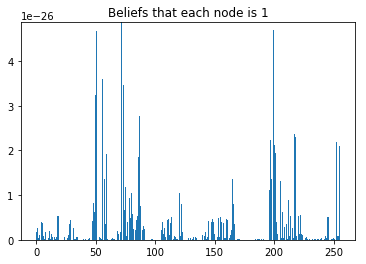

In [40]:
plt.bar(range(len(final_beliefs_on_1)),final_beliefs_on_1)
plt.title('Beliefs that each node is 1')

## (c) repeat 10 times 

In [255]:
def random_channel_noise_realizations(H,message,n_times_random,error_rate):
    Hamming_distances = []
    for n_time in range(n_times_random):
        Hamming_distance = []
        received = binary_symmetric_channel(message, error_rate)
        fg = construct_graph_with_H_and_observations(H, received)
        beliefs = get_beliefs(fg,n_iteration=50, saving_iterations=[1,5,10,20,30,40])
        for iteration in range(len([x for x in beliefs.values()][0])):
            decoded_codeword = decode_based_on_beliefs(beliefs,iteration)
            print(sum(list(decoded_codeword)))
            #Hamming_distance.append(sum(decoded_codeword))
        #Hamming_distances.append(Hamming_distance)
    return(Hamming_distances)    
    

In [256]:
#Construction of H
N = 128  # Number of columns
dim_codeword = 2*N
d_v = 1 # Number of ones per column, must be lower than d_c (because H must have more rows than columns)
d_c = 2 # Number of ones per row, must divide n (because if H has m rows: m*d_c = n*d_v (compute number of ones in H))
H = pyldpc.RegularH(N,d_v,d_c)
message = np.zeros(256, dtype=int)
ten_times_hamming_distances = random_channel_noise_realizations(H,message,10,0.05)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [254]:
ten_times_hamming_distances

[[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [87]:
from scipy.misc import imshow, imresize,imread
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Load and compress image
nyu_logo_realsize_color = imread('./photo.jpg')
nyu_logo_compressed_color = imresize(nyu_logo_realsize_color, (40,40))

In [202]:
def to_binary(img, threshold=10):
    binary = img.mean(2)>threshold
    return binary.astype(int)

In [203]:
# Change to binary bits
nyu_logo_binary_compressed = to_binary(nyu_logo_compressed_color,180)
# Construct 1600-bit message
nyu_logo_1600bit_message = nyu_logo_binary_compressed.reshape(-1)

In [204]:
# Encoding
n = 1600*2
d_v = 4
d_c = 8
H = pyldpc.RegularH(n, d_v, d_c)

In [205]:
H.shape

(1600, 3200)

In [206]:
new_H, sys_tG = pyldpc.CodingMatrix_systematic(H, use_sparse=True)

In [207]:
def generate_codeword(message, tG, error_rate):
    diff_dim = tG.shape[1]-message.shape[0]
    # Extend the original message to match generator
    message_extended = np.array(message.tolist()+[0]*diff_dim)
    codeword = binary_symmetric_channel(tG.dot(message_extended)%2, error_rate=error_rate)
    return codeword

In [208]:
# Generate codeword
nyu_logo_codeword = generate_codeword(nyu_logo_1600bit_message, sys_tG, error_rate=0.06)
# Decode
# Construct graph
fg_nyu_logo_codeword = construct_graph_with_H_and_observations(new_H, observations=nyu_logo_codeword, error_rate=0.06)
beliefs = get_beliefs(fg_nyu_logo_codeword, n_iteration=30, saving_iterations=[1,2,3,5,10,20])
decoded_prediction = decode_based_on_beliefs(beliefs)

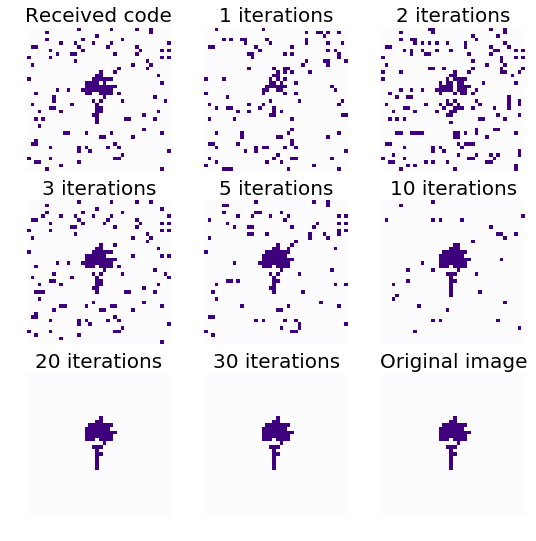

In [209]:
# Result plot
fig, axs = plt.subplots(3,3, figsize=(9, 9), facecolor='w', edgecolor='k')
axs = axs.reshape(-1)
iterations = [1,2,3,5,10,20,30]
ax0 = axs[0]
axs = axs[1:]
ax0.imshow(nyu_logo_codeword[:1600].reshape(40,40), cmap='Purples')
ax0.set_title('Received code', fontsize=20)
ax0.set_axis_off()
for i,prediction in enumerate(decoded_prediction):
    img_arr = prediction[:1600].reshape(40,40)
    axs[i].imshow(img_arr, cmap='Purples')
    axs[i].set_title('%d iterations'%iterations[i], fontsize=20)
    axs[i].set_axis_off()
axs[-1].imshow(nyu_logo_binary_compressed, cmap='Purples')
axs[-1].set_title('Original image', fontsize=20)
axs[-1].set_axis_off()

# Chow-Liu Algorithm

In [1]:
import numpy as np
def load_chowlui():
    input_matrix = []
    with open('chowliu-input.txt', 'r') as f:
        for line in f:
            input_matrix.append([int(token) for token in line.split()])
        
    return np.array(input_matrix)

In [2]:
def read_labels():
    input_labels = []
    with open('names.txt', 'r') as f:
        for line in f:
            input_labels.append(line.strip())
    return np.array(input_labels)

In [3]:
input_matrix = load_chowlui()
labels = read_labels()

In [29]:
labels

array(['airplane', 'armchair', 'awning', 'bag', 'balcony', 'ball', 'bars',
       'basket', 'bed', 'bench', 'boat', 'book', 'bookcase', 'books',
       'bottle', 'bottles', 'bowl', 'box', 'boxes', 'bread', 'building',
       'bus', 'cabinet', 'candle', 'car', 'cars', 'chair', 'chandelier',
       'clock', 'closet', 'clothes', 'counter', 'countertop', 'cupboard',
       'curtain', 'cushion', 'desk', 'dish', 'dishwasher', 'dome', 'door',
       'drawer', 'easel', 'fence', 'field', 'fireplace', 'floor',
       'flowers', 'gate', 'glass', 'grass', 'ground', 'handrail',
       'headstone', 'machine', 'microwave', 'mirror', 'monitor',
       'mountain', 'oven', 'path', 'person', 'picture', 'pillow', 'plant',
       'plate', 'platform', 'poster', 'pot', 'railing', 'refrigerator',
       'river', 'road', 'rock', 'rocks', 'rug', 'sand', 'screen', 'sea',
       'seats', 'shelves', 'shoes', 'showcase', 'sign', 'sink', 'sky',
       'sofa', 'staircase', 'stand', 'steps', 'stone', 'stones', 'stool'

In [4]:
import scipy.sparse.csgraph
# Now we have chow-lui input matrix, which has one row for each picture, and a column for each item
# The method count_both_item_matrix: create two matrices
# 1) both_count_matrix:
# When i > j: M[i][j] = counts items i and j occurs together.
# When i == j: M[i][j] = counts item i appears in the data set.
# When i < j: M[i][j] = zero. This position is not used.
# 2) single_count_matrix:
# When i != j: N[i][j] = counts items i occurs and j not occurs.
# When i == j: N[i][j] = zero. This position is not used.

def count_both_item_matrix(input_matrix):
    matrix_shape = input_matrix.shape[1]
    both_count_matrix = np.zeros((matrix_shape, matrix_shape), dtype=int)
    single_count_matrix = np.zeros((matrix_shape, matrix_shape), dtype=int)
    #Get each item from each picture
    for row in input_matrix:
        for i in range(len(row)):
            for j in range(len(row)):
                #item i and j both occur together in a picture
                if i > j and row[i] == 1 and row[j] == 1:
                    both_count_matrix[i][j] += 1
                #item i occurs but j does not occur
                if row[i] == 1 and row[j] == 0:
                    single_count_matrix[i][j] += 1
            #item i occurs no matter j occurs or not
            if row[i] == 1:
                both_count_matrix[i][i] += 1
    return both_count_matrix, single_count_matrix

both_count_matrix, single_count_matrix = count_both_item_matrix(input_matrix)

In [5]:
single_count_matrix

array([[   0,   35,   36, ...,   32,   35,   32],
       [ 143,    0,  144, ...,    3,  144,   75],
       [  90,   90,    0, ...,   80,   90,   39],
       ..., 
       [2006, 1869, 2000, ...,    0, 1997, 1316],
       [ 146,  147,  147, ...,  134,    0,  137],
       [1174, 1109, 1127, ...,  484, 1168,    0]])

In [6]:
# Create a matrix that has the mutual information between each item,
# based on their empirical probabilities.
# Take the inverse of the mutual information, use minimum spanning tree to find the maximum spanning tree.
import itertools
import math
import numpy.ma as ma

In [7]:
# Computes one part of the sum of the "empirical" mutual information between x_i and x_j.
def mutual_info_part(num_xixj, num_xi, num_xj, total):
    if not num_xixj or not num_xi or not num_xj:
        return 0.0
    p_xixj = 1.0 * num_xixj / total
    p_xi = 1.0 * num_xi / total
    p_xj = 1.0 * num_xj / total
    return p_xixj * math.log(p_xixj / (p_xi * p_xj), 2)

In [8]:
def mutual_info(i, j, num_data, both_count_matrix, single_count_matrix):
    num_xi_one = both_count_matrix[i][i]
    num_xj_one = both_count_matrix[j][j]
    num_xi_zero = num_data - num_xi_one
    num_xj_zero = num_data - num_xj_one
    info = 0.0
    # i=1 and j=1 case
    info += mutual_info_part(both_count_matrix[i][j], num_xi_one, num_xj_one, num_data)
    # i=1 and j=0 case
    info += mutual_info_part(single_count_matrix[i][j], num_xi_one, num_xj_zero, num_data)
    # i=0 and j=1 case
    info += mutual_info_part(single_count_matrix[j][i], num_xi_zero, num_xj_one, num_data)
    # i=0 and j=0 case
    neither_count = (num_data - both_count_matrix[i][j] - single_count_matrix[i][j]
    - single_count_matrix[j][i])
    info += mutual_info_part(neither_count, num_xi_zero, num_xj_zero, num_data)
    assert (neither_count + both_count_matrix[i][j] + single_count_matrix[i][j]
    + single_count_matrix[j][i] == num_data)
    return info

In [9]:
# Create a matrix where each value is the inverse of the mutual information values
# between each item.
def create_inv_mutual_info_matrix(num_data, both_count_matrix, single_count_matrix):
    inv_info_matrix = np.zeros(both_count_matrix.shape)
    # Create a mask for the upper right corner, to mark this matrix as triangular.
    info_mask = np.zeros(both_count_matrix.shape, dtype=int)
    num_items = both_count_matrix.shape[1]
    for i in range(num_items):
        for j in range(i):
            info = mutual_info(i, j, num_data, both_count_matrix, single_count_matrix)
            inv_info_matrix[i][j] = 1.0 / info
        for j in range(i, num_items):
            info_mask[i][j] = 1
    inv_info_matrix = ma.array(inv_info_matrix, mask=info_mask)
    return inv_info_matrix

In [10]:
num_data = input_matrix.shape[0]
inv_info_matrix = create_inv_mutual_info_matrix(num_data, both_count_matrix, single_count_matrix)

In [21]:
import scipy.sparse.csgraph
"""
A minimum spanning tree is a graph consisting of the subset of edges 
which together connect all connected nodes, while minimizing the total
sum of weights on the edges. This is computed using the Kruskal algorithm
"""
mst_rows, mst_columns = scipy.sparse.csgraph.minimum_spanning_tree(inv_info_matrix).nonzero()
mst_edge_pairs = zip(mst_rows, mst_columns)

In [12]:
# Code for calculating the potential functions on nodes and edges, now that we have the
# structure of the tree.
def edge_part(num_xixj, num_xi, num_xj, total):
    p_xixj = 1.0 * num_xixj / total
    p_xi = 1.0 * num_xi / total
    p_xj = 1.0 * num_xj / total
    return p_xixj / (p_xi * p_xj)

In [13]:
def edge_potential(i, j, num_data, both_count_matrix, single_count_matrix):
    num_xi_one = both_count_matrix[i][i]
    num_xj_one = both_count_matrix[j][j]
    num_xi_zero = num_data - num_xi_one
    num_xj_zero = num_data - num_xj_one
    potential = np.zeros((2, 2))
    # i=1 and j=1 case
    potential[1][1] = edge_part(both_count_matrix[i][j], num_xi_one, num_xj_one, num_data)
    # i=1 and j=0 case
    potential[1][0] = edge_part(single_count_matrix[i][j], num_xi_one, num_xj_zero, num_data)
    # i=0 and j=1 case
    potential[0][1] = edge_part(single_count_matrix[j][i], num_xi_zero, num_xj_one, num_data)
    # i=0 and j=0 case
    neither_count = (num_data - both_count_matrix[i][j] - single_count_matrix[i][j]
    - single_count_matrix[j][i])
    potential[0][0] = edge_part(neither_count, num_xi_zero, num_xj_zero, num_data)
    assert (neither_count + both_count_matrix[i][j] + single_count_matrix[i][j]
    + single_count_matrix[j][i] == num_data)
    return potential

In [14]:
def node_potential(i, num_data, both_count_matrix):
    num_xi_one = both_count_matrix[i][i]
    num_xi_zero = num_data - num_xi_one
    return np.array([float(num_xi_one) / num_data, float(num_xi_zero) / num_data])

In [15]:
def create_graph_potentials(mst_edge_pairs, num_data,
    both_count_matrix, single_count_matrix):
    # Every node i has a 1x2 potential matrix
    node_potentials = np.ndarray((both_count_matrix.shape[0], 2))
    # Every edge (i,j) has a 2x2 potential matrix.
    edge_potentials = np.ndarray((both_count_matrix.shape[0], both_count_matrix.shape[1],
    2, 2))
    num_items = both_count_matrix.shape[1]
    for i in range(num_items):
        for j in range(i):
            edge_potentials[i][j] = edge_potential(i, j, num_data, both_count_matrix,single_count_matrix)
        node_potentials[i] = node_potential(i, num_data, both_count_matrix)
    return node_potentials, edge_potentials

In [16]:
node_potentials, edge_potentials = create_graph_potentials(
    mst_edge_pairs, num_data, both_count_matrix, single_count_matrix)

In [22]:
# Creates a string that reprsents the Markov random field in UAI format.
# http://www.hlt.utdallas.edu/~vgogate/uai14-competition/modelformat.html
def create_graph_as_uai_file(mst_edge_pairs, node_potentials, edge_potentials):
    num_vars = node_potentials.shape[0]
    network_type = 'MARKOV'
    num_vars_str = str(num_vars)
    var_cardinals = ' '.join(['2']*num_vars)
    num_cliques = str(sum(1 for _ in mst_edge_pairs) + num_vars)
    node_cliques = ['1 ' + str(i) for i in range(num_vars)]
    edge_cliques = [' '.join(['2', str(i), str(j)]) for i, j in mst_edge_pairs]
    preamble = ([network_type, num_vars_str, var_cardinals, num_cliques] + node_cliques
    + edge_cliques)
    function_tables = []
    # node potentials
    for i in range(num_vars):
        prob_str = ' '.join([' ', str(node_potentials[i][0]), str(node_potentials[i][1])])
        function_tables += ['', '2', prob_str]
    # edge potentials
    for i, j in mst_edge_pairs:
        assert i > j
        prob00 = edge_potentials[i][j][0][0]
        prob01 = edge_potentials[i][j][0][1]
        prob_str1 = ' '.join([' ', str(prob00), str(prob01)])
        prob10 = edge_potentials[i][j][1][0]
        prob11 = edge_potentials[i][j][1][1]
        prob_str2 = ' '.join([' ', str(prob10), str(prob11)])
        function_tables += ['', '4', prob_str1, prob_str2]
    return '\n'.join(preamble + function_tables + [''])

In [23]:
uai_str = create_graph_as_uai_file(mst_edge_pairs, node_potentials, edge_potentials)
with open ('hw5_prob2.uai', 'w') as f:
    f.write(uai_str)

In [25]:
mst_edge_pairs = zip(mst_rows, mst_columns)
all_pairs = list(mst_edge_pairs)

In [26]:
for (i, j) in all_pairs:
    print (i, j, labels[i], '--', labels[j], ":", edge_potentials[i][j][1][1])

13 11 books -- book : 17.8188951664
13 12 books -- bookcase : 32.2502421308
15 14 bottles -- bottle : 21.8532110092
18 17 boxes -- box : 13.7630003152
20 2 building -- awning : 2.83260887878
20 4 building -- balcony : 3.15318242536
22 16 cabinet -- bowl : 15.1463651498
25 24 cars -- car : 7.9865994979
32 22 countertop -- cabinet : 19.6495829675
35 8 cushion -- bed : 12.1792726461
36 26 desk -- chair : 5.25427127617
36 28 desk -- clock : 6.07160236357
39 20 dome -- building : 2.81421531463
40 6 door -- bars : 3.19225146199
41 22 drawer -- cabinet : 15.4129411765
45 1 fireplace -- armchair : 15.1631944444
46 1 floor -- armchair : 2.60851983636
46 13 floor -- books : 2.42753607988
46 20 floor -- building : 0.0921954638603
46 26 floor -- chair : 2.34104808146
46 27 floor -- chandelier : 2.52800622804
47 23 flowers -- candle : 12.0635359116
51 46 ground -- floor : 0.0828942173358
52 40 handrail -- door : 2.77395644283
53 50 headstone -- grass : 7.11527494908
54 0 machine -- airplane : 20.21